In [2]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from unet import Unet_model
from Modules import STFT

# dataset

In [3]:
from torch.utils.data import Dataset
import os
import torchaudio as ta
from IPython.display import Audio
from matplotlib import pyplot as plt
torch.manual_seed(0)

def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise

class my_dataset(Dataset):
    def __init__(self, path):
        self.path_signal = os.listdir(f'{path}/mic')
        self.path_target = f'{path}/target'
        self.path_mic = f'{path}/mic'
        self.noise = torch.rand(1,53768)
        
    def __len__(self):
        return len(self.path_signal)
    
    def __getitem__(self, idx):
        path = self.path_signal[idx]
        
        target, sample_rate = ta.load(f'{self.path_target}/{path}')
        mic_array, sample_rate = ta.load(f'{self.path_mic}/{path}')
        
        target = F.pad(target, (0, mic_array.shape[-1] - target.shape[-1]))
        return  target, mic_array

In [4]:
def plot_magn(magn, title):
    plt.title(title)
    plt.imshow(torch.log(magn+ 1e-5).detach(), cmap="viridis", origin="lower", aspect="auto")
    plt.show();
    
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

In [5]:
data_train = my_dataset('./beam_data/train')
data_valid = my_dataset('./beam_data/valid')

In [6]:
train_target = data_train[2][0]
train_sample = data_train[2][1]

In [7]:
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

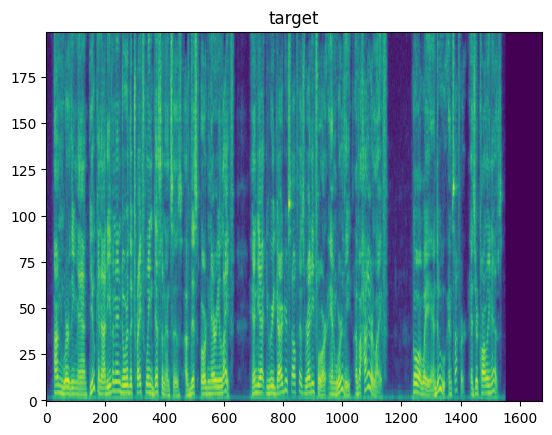

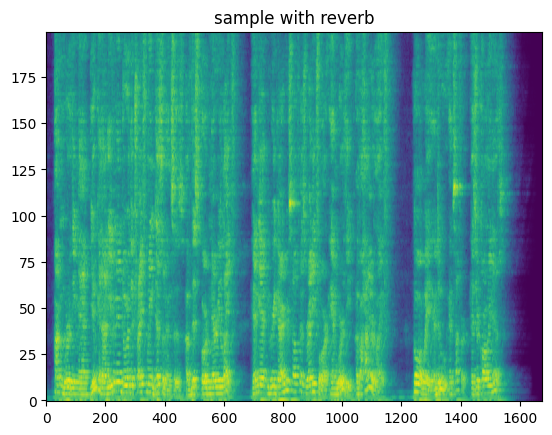

In [12]:
plot_magn(stft.stft(train_target).abs()[0], 'target')
plot_magn(stft.stft(train_sample).abs()[0], 'sample with reverb')

In [13]:
Audio(train_sample, rate=16000)

In [14]:
Audio(train_target, rate=16000)

# train

In [15]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalDistortionRatio

In [16]:
from torch.utils.data import DataLoader
from loss import MultiResSpecLoss

In [17]:
# init

train_dataloader = DataLoader(data_train, batch_size=1, shuffle=False)
test_dataloader = DataLoader(data_valid, batch_size=1, shuffle=False)

unet_mask = Unet_model()
si = ScaleInvariantSignalDistortionRatio()
losses_epoch_train = []
metrics_epoch_train = []
losses_epoch_valid = []
metrics_epoch_valid = []
lrs = []
epochs = 100
criterion = nn.MSELoss()#MultiResSpecLoss(n_ffts=[1024, 400],f_complex=100, factor=100, gamma=0.3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optim = torch.optim.Adam(unet_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=50
        )
unet_mask.to(device);

In [18]:
import logging
import logging.config

LOGGER = logging.getLogger("Train")
LOGGER.setLevel(logging.DEBUG)
file_handler = logging.FileHandler("reverb.log")
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(message)s")
file_handler.setFormatter(formatter)
LOGGER.addHandler(file_handler)
LOGGER.info(f"epchs, train_loss, train_metric, valid_loss, valid_metric")

In [19]:
import torch as th

def pipline(model, sample):
    spec_sample = stft.stft(sample)
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)
    mask = model(spec_sample)
    mag_predict = mag * mask
    
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, sample.shape[-1])
    return wave_predict

In [20]:
mn = -100
for epoch in tqdm(range(epochs)):
    losses_train = []
    metrics_train = []
    unet_mask.train()
    for batch_idx, batch in enumerate(train_dataloader):
        optim.zero_grad()
        target, sample = batch
        predictions = pipline(unet_mask, sample.to(device))
        
        loss = criterion(predictions, target.to(device))
        loss.backward()
        optim.step()
        
        metrics_train.append(si(predictions.detach().cpu(), target.cpu()))
        losses_train.append(loss.item())
    
    losses_epoch_train.append(sum(losses_train)/len(losses_train))
    metrics_epoch_train.append(sum(metrics_train)/len(metrics_train))
    
    losses_val = []
    metrics_val = []
    unet_mask.eval()    
    for batch_idx, batch in enumerate(test_dataloader):
        target, sample = batch
        predictions = pipline(unet_mask, sample.to(device))
        
        loss = criterion(predictions, target.to(device))
        
        metrics_val.append(si(predictions.detach().cpu(), target.cpu()))
        losses_val.append(loss.item())
        
    losses_epoch_valid.append(sum(losses_val)/len(losses_val))
    metrics_epoch_valid.append(sum(metrics_val)/len(metrics_val))
    
    lrs.append(scheduler.get_lr()[0])
    scheduler.step()
    # print("Epoch [{}/{}], train_loss: {:.4f}, train_metric: {:.4f}, valid_loss: {:.4f}, valid_metric: {:.4f}".format(epoch+1, epochs, 
    #                                                                                                                  losses_epoch_train[-1], 
    #                                                                                                                  metrics_epoch_train[-1], 
    #                                                                                                                  losses_epoch_valid[-1], 
    #                                                                                                                  metrics_epoch_valid[-1]))
    
    LOGGER.info(f"{epoch+1},{losses_epoch_train[-1]},{metrics_epoch_train[-1]},{losses_epoch_valid[-1]},{metrics_epoch_valid[-1]}")
    if mn < metrics_epoch_valid[-1]:
        mn = metrics_epoch_valid[-1]
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': unet_mask.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses_epoch_train[-1],
            }, f'checkpoint_reverb.pt')

  0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]C:\Users\Максим\venv_n\lib\site-packages\torch\optim\lr_scheduler.py:1379: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  1%|█▏                                                                                                                 | 1/100 [03:20<5:30:19, 200.20s/it]


KeyboardInterrupt: 